# Dependencies

In [3]:
!pip install -q datasets

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import torch
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
import copy

import spacy
from tqdm import tqdm
import re
import string
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Make dataset

## Base Dataset

In [5]:
data = load_dataset("stanfordnlp/sst2")

README.md:   0%|          | 0.00/5.27k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

## Dataset Version 1

In [6]:
new_data = load_dataset("aayya/sst2-augmented")

README.md:   0%|          | 0.00/521 [00:00<?, ?B/s]

sst2_train_orig.csv:   0%|          | 0.00/3.84M [00:00<?, ?B/s]

sst2_train_orig_eda.csv:   0%|          | 0.00/7.65M [00:00<?, ?B/s]

sst2_train_orig_eda_embedding.csv:   0%|          | 0.00/11.5M [00:00<?, ?B/s]

(…)st2_train_orig_eda_embedding_wordnet.csv:   0%|          | 0.00/15.3M [00:00<?, ?B/s]

sst2_val.csv:   0%|          | 0.00/95.9k [00:00<?, ?B/s]

Generating train_orig split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating train_orig_eda split:   0%|          | 0/134698 [00:00<?, ? examples/s]

Generating train_orig_eda_embedding split:   0%|          | 0/202047 [00:00<?, ? examples/s]

Generating train_orig_eda_embedding_wordnet split:   0%|          | 0/269394 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/872 [00:00<?, ? examples/s]

In [7]:
%cd /kaggle/working

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

!rm /kaggle/working/glove.6B.200d.txt
!rm /kaggle/working/glove.6B.100d.txt
!rm /kaggle/working/glove.6B.50d.txt
!rm /kaggle/working/glove.6B.zip

/kaggle/working
--2025-04-07 07:59:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-07 07:59:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-07 07:59:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glo

In [8]:
def load_glove(path):

    words = pd.read_table(path, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

    embedding = words.values
    words = words.index.to_numpy()

    print("The embedding size is {}, and the number of words is {}".format(embedding.shape[1], embedding.shape[0]))
    return words, embedding


def tokenize_data(dataset):
    tokenizer = spacy.blank("en")
    data, labels = [], []
    
    for sample in dataset:
        if not isinstance(sample["sentence"], str) or \
           not isinstance(sample["label"], int):
            continue
        sentence_sample = sample["sentence"].strip().lower()

        sentence = [token.text for token in tokenizer(sentence_sample)]
        data.append(sentence)
        labels.append(sample["label"])

    return data, torch.LongTensor(labels)


def embedding_transform(vocab, words, embedding):
    word_to_idx = vocab[1]
    num_words = len(vocab[0])
    embedding_size = embedding.shape[1]
    transformed_embedding = np.zeros((num_words, embedding_size))

    all_words_dict = {word: idx for idx, word in enumerate(words)}
    unk_id = all_words_dict['unknown']

    unknown_words = []
    for token in word_to_idx.keys():         
        idx = word_to_idx[token]
        if idx == 0:
            continue
            
        token_id = all_words_dict.get(token, -1)
        
        if token_id != -1:
            transformed_embedding[idx,] = embedding[token_id,]
        else:
            transformed_embedding[idx,] = embedding[unk_id,]
            unknown_words.append(token)

    return torch.tensor(transformed_embedding, dtype=torch.float), unknown_words

def build_vocab(data, min_freq=1):
    
    from collections import Counter
    counter = Counter()
    
    for tokens in data:
        counter.update(tokens)

    words = ["<pad>", "<unk>"] + [word for word, freq in counter.items() if freq >= min_freq]
    word2idx = {word: idx for idx, word in enumerate(words)}

    return (words, word2idx)


def data_indexing(data, word2idx):
    indexed_data = []
    
    for sentence in data:
        word_ids = torch.tensor([word2idx.get(token, 1) for token in sentence], \
                                dtype=torch.long)
        indexed_data.append(word_ids)

    return indexed_data

In [9]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def collate_fn(batch):
    inputs, labels = zip(*batch)

    lengths = torch.tensor([len(seq) for seq in inputs])
    sorted_idx = torch.argsort(lengths, descending=True)

    inputs = [inputs[i] for i in sorted_idx]
    labels = torch.tensor([labels[i] for i in sorted_idx])

    inputs = pad_sequence(inputs, batch_first=True)

    return inputs, labels, lengths[sorted_idx]
    

In [52]:
# data transformation
print("START CREATING DATASET...")

version_data = {0: "train_orig", 
                1: "train_orig_eda", 
                2: "train_orig_eda_embedding", 
                3: "train_orig_eda_embedding_wordnet"}

train_data, train_labels = tokenize_data(new_data[version_data[3]])
val_data, val_labels = tokenize_data(new_data["val"])
# test_data, test_labels = tokenize_data(data["test"])
print("SUCCESSFULLY LOADING DATASET!!!")

START CREATING DATASET...


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


SUCCESSFULLY LOADING DATASET!!!


In [53]:
vocab = build_vocab(train_data)
words, embedding = load_glove(path="/kaggle/working/glove.6B.300d.txt")

transformed_embedding, unknown_words = embedding_transform(vocab, words, embedding)
print("There are {} words out of the pre-trained vocabulary.".format(len(unknown_words)))

The embedding size is 300, and the number of words is 400000
There are 1529 words out of the pre-trained vocabulary.


In [54]:
train_data = data_indexing(train_data, vocab[1])
val_data = data_indexing(val_data, vocab[1])

# build datasets
train_dataset = MyDataset(train_data, train_labels)
val_dataset = MyDataset(val_data, val_labels)

# build dataloaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, drop_last=True, collate_fn=collate_fn)
print("DONE CREATING DATASET!!!\n")

DONE CREATING DATASET!!!



# Model Zoo

## LSTM

In [13]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

    def forward(self, encoder_outputs):
        energy = self.projection(encoder_outputs)
        weights = F.softmax(energy.squeeze(-1), dim=1)
        outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)
        return outputs


class LSTM(nn.Module):
    def __init__(self, embedding, embed_size, vocab_size, hidden_dim, num_layers=2):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        
        if embedding != None:
            self.embedding.weight = nn.Parameter(embedding)
            self.embedding.weight.requires_grad = True

        self.embed_size = embed_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(embed_size,
                            hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=0.1)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, inputs, lengths):
        embeds = self.embedding(inputs)

        packed_emb = nn.utils.rnn.pack_padded_sequence(embeds, lengths, batch_first=True)
        out, _ = self.lstm(packed_emb)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)        
        embedding = self.attention(out)
        
        outputs = self.fc(embedding)
        
        return outputs

## RNN

In [14]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

    def forward(self, encoder_outputs):
        energy = self.projection(encoder_outputs)
        weights = F.softmax(energy.squeeze(-1), dim=1)
        outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)
        return outputs


class RNN(nn.Module):
    def __init__(self, embedding, embed_size, vocab_size, hidden_dim, num_layers=2):
        super(RNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        if embedding != None:
            self.embedding.weight = nn.Parameter(embedding)
            self.embedding.weight.requires_grad = True

        self.embed_size = embed_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.rnn = nn.RNN(embed_size,
                          hidden_dim,
                          num_layers=num_layers,
                          batch_first=True,
                          dropout=0.1)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, inputs, lengths):
        embeds = self.embedding(inputs)

        packed_emb = nn.utils.rnn.pack_padded_sequence(embeds, lengths, batch_first=True)
        out, _ = self.rnn(packed_emb)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)        
        embedding = self.attention(out)
        
        outputs = self.fc(embedding)
        
        return outputs

## ANN

In [15]:
class MLPBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.act1 = nn.ReLU()
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(0.05)

        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.act2 = nn.ReLU()
        self.norm2 = nn.LayerNorm(output_dim)
        self.dropout2 = nn.Dropout(0.05)       

    def forward(self, x):
        x1 = self.dropout1(self.norm1(self.act1(self.fc1(x))))
        
        return self.dropout2(self.norm2(self.act2(self.fc2(x1))))

class ANN(nn.Module):
    def __init__(self, embedding, embed_size, vocab_size, hidden_dim, num_layers=5):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        if embedding != None:
            self.embedding.weight = nn.Parameter(embedding)
            self.embedding.weight.requires_grad = True

        self.first_hidden = nn.Linear(embed_size, hidden_dim)
        
        self.hidden_layers = nn.Sequential(*[
            MLPBlock(hidden_dim, 2*hidden_dim, hidden_dim) for _ in range(num_layers)
        ])

        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, inputs, lengths=None):
        batch_size = inputs.size(0)
        
        embeds = self.embedding(inputs)
        hidden_inp = self.first_hidden(embeds)
        
        output = self.fc(self.hidden_layers(hidden_inp)).view(batch_size, -1).sum(-1)

        return output

# Trainer

In [19]:
class Trainer():

    def __init__(self, model_name, model, epochs, train_dataloader, val_dataloader, 
                 criterion, optimizer, lr_decay, lr_scheduler, device):

        self.model_name = model_name
        self.model = model
        self.epochs = epochs
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_decay = lr_decay
        self.lr_scheduler = lr_scheduler
        self.device = device

        self.model.to(self.device)

    def train(self):

        trainable = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        total = sum(param.numel() for param in self.model.parameters())
        model_params = 'total parameters: {}, trainable parameters: {}'.format(total, trainable)
        print(model_params)

        for epoch in range(self.epochs):
            self.model.train()
            train_loss, val_loss = [], []

            # training
            for batch_data in tqdm(self.train_dataloader,
                                   total=len(self.train_dataloader)):
            
                inputs = batch_data[0].to(self.device)
                labels = batch_data[1].to(self.device)
                lengths = batch_data[2]

                self.optimizer.zero_grad()
                outputs = self.model(inputs, lengths)
                loss = self.criterion(outputs.view(-1), labels.float())
                loss.backward()
                self.optimizer.step()

                train_loss.append(loss.item())

            epoch_train_loss = np.mean(train_loss)        
            precision, recall, f1 = self.multi_metrics_validate(self.val_dataloader)
            
            train_message = '[ Epoch {}, Train ] | Train-Loss:{:.5f} | Train-Acc:{:.5f} | Val-Acc:{:.5f} | Precision:{:.5f} | Recall:{:.5f} | F1-Score:{:.5f}' \
                                .format(epoch, 
                                        epoch_train_loss,
                                        self.only_acc_validate(self.train_dataloader),
                                        self.only_acc_validate(self.val_dataloader),
                                        precision,
                                        recall,
                                        f1)
            print(train_message)

            if self.lr_decay:
                self.lr_scheduler.step()

            save_path = f"{self.model_name}_e{epoch}.pt"
            torch.save(self.model.state_dict(), save_path)

        print("End evaluating!!!")

    def batch_validate(self, preds, labels):
        preds = torch.round(torch.sigmoid(preds.squeeze(-1)))
        num_true_labels = (preds == labels).sum()

        return num_true_labels / len(labels)

    def round_preds(self, preds):
        return torch.round(
            torch.sigmoid(preds.squeeze(-1))
        ).int()

    def multi_metrics_validate(self, dataloader):
        self.model.eval()
        
        all_labels, all_preds = [], []
        
        with torch.no_grad():
            for batch_data in dataloader:
                inputs = batch_data[0].to(self.device)
                labels = batch_data[1].to(self.device)
                lengths = batch_data[2]

                preds = self.round_preds(self.model(inputs, lengths))

                all_labels.extend(labels.tolist())
                all_preds.extend(preds.tolist())

        precision, recall, f1 = self.precision_recall_f1_validate(all_labels, all_preds)
                        
        return (precision, recall, f1)

    def only_acc_validate(self, dataloader):
        self.model.eval()
        
        val_acc = 0
        all_labels, all_preds = [], []
        
        with torch.no_grad():
            for batch_data in dataloader:
                inputs = batch_data[0].to(self.device)
                labels = batch_data[1].to(self.device)
                lengths = batch_data[2]

                preds = self.round_preds(self.model(inputs, lengths))

                all_labels.extend(labels.tolist())
                all_preds.extend(preds.tolist())
                        
        return self.batch_validate(torch.tensor(all_preds), torch.tensor(all_labels))

    def confusion_mat_visualize(self, labels, preds):
        conf_matrix = confusion_matrix(labels, preds)
        
        plt.figure(figsize=(7,6))
        sns.set(font_scale = 1.5)
         
        ax = sns.heatmap(
            conf_matrix,
            annot=True,
            fmt='d',
            cbar_kws={"shrink": 0.8, "aspect": 30}
        )
         
        ax.set_xlabel("Predicted", labelpad=20)
        ax.set_ylabel("Actual", labelpad=20)
        plt.show()

    def precision_recall_f1_validate(self, labels, preds):
        precision = precision_score(labels, preds)
        recall = recall_score(labels, preds)
        f1score = f1_score(labels, preds)
         
        return precision, recall, f1score

# Training

## ANN Training

In [55]:
ann_model = ANN(None,
                embed_size=transformed_embedding.size(1),
                vocab_size=len(vocab[0]),
                hidden_dim=256)

optimizer = torch.optim.Adam(ann_model.parameters(), lr=5e-5, weight_decay=4e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.BCEWithLogitsLoss().to(device)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                               step_size=8, 
                                               gamma=0.5, 
                                               verbose=True)
epochs, lr_decay = 10, True

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [56]:
trainer = Trainer(model_name="ann",
                  model=ann_model,
                  epochs=epochs,
                  train_dataloader=train_loader,
                  val_dataloader=val_loader,
                  criterion=criterion,
                  optimizer=optimizer,
                  lr_decay=lr_decay,
                  lr_scheduler=lr_scheduler,
                  device=device)

trainer.train()

total parameters: 9033053, trainable parameters: 9033053


100%|██████████| 1052/1052 [00:30<00:00, 34.48it/s]


[ Epoch 0, Train ] | Train-Loss:0.78378 | Train-Acc:0.80019 | Val-Acc:0.79427 | Precision:0.79897 | Recall:0.79487 | F1-Score:0.79692


100%|██████████| 1052/1052 [00:30<00:00, 34.62it/s]


[ Epoch 1, Train ] | Train-Loss:0.50440 | Train-Acc:0.85234 | Val-Acc:0.79688 | Precision:0.78818 | Recall:0.82051 | F1-Score:0.80402


100%|██████████| 1052/1052 [00:30<00:00, 34.58it/s]


[ Epoch 2, Train ] | Train-Loss:0.41204 | Train-Acc:0.87535 | Val-Acc:0.79948 | Precision:0.78922 | Recall:0.82564 | F1-Score:0.80702


100%|██████████| 1052/1052 [00:30<00:00, 34.63it/s]


[ Epoch 3, Train ] | Train-Loss:0.35614 | Train-Acc:0.89474 | Val-Acc:0.79688 | Precision:0.75885 | Recall:0.87949 | F1-Score:0.81473


100%|██████████| 1052/1052 [00:30<00:00, 34.58it/s]


[ Epoch 4, Train ] | Train-Loss:0.31653 | Train-Acc:0.90735 | Val-Acc:0.80599 | Precision:0.77958 | Recall:0.86154 | F1-Score:0.81851


100%|██████████| 1052/1052 [00:30<00:00, 34.74it/s]


[ Epoch 5, Train ] | Train-Loss:0.29098 | Train-Acc:0.91391 | Val-Acc:0.81250 | Precision:0.79009 | Recall:0.85897 | F1-Score:0.82310


100%|██████████| 1052/1052 [00:30<00:00, 34.61it/s]


[ Epoch 6, Train ] | Train-Loss:0.27061 | Train-Acc:0.92036 | Val-Acc:0.79818 | Precision:0.76765 | Recall:0.86410 | F1-Score:0.81303


100%|██████████| 1052/1052 [00:30<00:00, 34.68it/s]


[ Epoch 7, Train ] | Train-Loss:0.25341 | Train-Acc:0.92357 | Val-Acc:0.79297 | Precision:0.74839 | Recall:0.89231 | F1-Score:0.81404


100%|██████████| 1052/1052 [00:30<00:00, 34.67it/s]


[ Epoch 8, Train ] | Train-Loss:0.23443 | Train-Acc:0.92799 | Val-Acc:0.78255 | Precision:0.73375 | Recall:0.89744 | F1-Score:0.80738


100%|██████████| 1052/1052 [00:30<00:00, 34.70it/s]


[ Epoch 9, Train ] | Train-Loss:0.22587 | Train-Acc:0.93007 | Val-Acc:0.78255 | Precision:0.73673 | Recall:0.88974 | F1-Score:0.80604
End evaluating!!!


## RNN Training

In [57]:
rnn_model = RNN(None,
                embed_size=transformed_embedding.size(1),
                vocab_size=len(vocab[0]),
                hidden_dim=256)

optimizer = torch.optim.Adam(rnn_model.parameters(), lr=5e-5, weight_decay=4e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.BCEWithLogitsLoss().to(device)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                               step_size=8, 
                                               gamma=0.5, 
                                               verbose=True)
epochs, lr_decay = 10, True

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [58]:
trainer = Trainer(model_name="rnn",
                  model=rnn_model,
                  epochs=epochs,
                  train_dataloader=train_loader,
                  val_dataloader=val_loader,
                  criterion=criterion,
                  optimizer=optimizer,
                  lr_decay=lr_decay,
                  lr_scheduler=lr_scheduler,
                  device=device)

trainer.train()

total parameters: 7924702, trainable parameters: 7924702


100%|██████████| 1052/1052 [00:16<00:00, 62.44it/s]


[ Epoch 0, Train ] | Train-Loss:0.62108 | Train-Acc:0.69556 | Val-Acc:0.68750 | Precision:0.67281 | Recall:0.74872 | F1-Score:0.70874


100%|██████████| 1052/1052 [00:16<00:00, 62.82it/s]


[ Epoch 1, Train ] | Train-Loss:0.52154 | Train-Acc:0.76827 | Val-Acc:0.74089 | Precision:0.72055 | Recall:0.80000 | F1-Score:0.75820


100%|██████████| 1052/1052 [00:16<00:00, 62.71it/s]


[ Epoch 2, Train ] | Train-Loss:0.43226 | Train-Acc:0.80409 | Val-Acc:0.74609 | Precision:0.75194 | Recall:0.74615 | F1-Score:0.74903


100%|██████████| 1052/1052 [00:16<00:00, 62.56it/s]


[ Epoch 3, Train ] | Train-Loss:0.38248 | Train-Acc:0.82721 | Val-Acc:0.74219 | Precision:0.70513 | Recall:0.84615 | F1-Score:0.76923


100%|██████████| 1052/1052 [00:16<00:00, 62.76it/s]


[ Epoch 4, Train ] | Train-Loss:0.34863 | Train-Acc:0.84413 | Val-Acc:0.75000 | Precision:0.71336 | Recall:0.84872 | F1-Score:0.77518


100%|██████████| 1052/1052 [00:16<00:00, 62.27it/s]


[ Epoch 5, Train ] | Train-Loss:0.32406 | Train-Acc:0.85255 | Val-Acc:0.75781 | Precision:0.76020 | Recall:0.76410 | F1-Score:0.76215


100%|██████████| 1052/1052 [00:16<00:00, 62.25it/s]


[ Epoch 6, Train ] | Train-Loss:0.30459 | Train-Acc:0.86386 | Val-Acc:0.75651 | Precision:0.72606 | Recall:0.83590 | F1-Score:0.77712


100%|██████████| 1052/1052 [00:16<00:00, 62.55it/s]


[ Epoch 7, Train ] | Train-Loss:0.28717 | Train-Acc:0.87411 | Val-Acc:0.77474 | Precision:0.74165 | Recall:0.85385 | F1-Score:0.79380


100%|██████████| 1052/1052 [00:16<00:00, 62.76it/s]


[ Epoch 8, Train ] | Train-Loss:0.26414 | Train-Acc:0.88259 | Val-Acc:0.75000 | Precision:0.72098 | Recall:0.82821 | F1-Score:0.77088


100%|██████████| 1052/1052 [00:16<00:00, 62.55it/s]


[ Epoch 9, Train ] | Train-Loss:0.25668 | Train-Acc:0.88533 | Val-Acc:0.75651 | Precision:0.76364 | Recall:0.75385 | F1-Score:0.75871
End evaluating!!!


## LSTM Training

In [59]:
lstm_model = LSTM(None,
                  embed_size=transformed_embedding.size(1),
                  vocab_size=len(vocab[0]),
                  hidden_dim=256)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=5e-5, weight_decay=4e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.BCEWithLogitsLoss().to(device)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                               step_size=8, 
                                               gamma=0.5, 
                                               verbose=True)
epochs, lr_decay = 10, True

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [60]:
trainer = Trainer(model_name="lstm",
                  model=lstm_model,
                  epochs=epochs,
                  train_dataloader=train_loader,
                  val_dataloader=val_loader,
                  criterion=criterion,
                  optimizer=optimizer,
                  lr_decay=lr_decay,
                  lr_scheduler=lr_scheduler,
                  device=device)

trainer.train()

total parameters: 8747998, trainable parameters: 8747998


100%|██████████| 1052/1052 [00:19<00:00, 52.67it/s]


[ Epoch 0, Train ] | Train-Loss:0.61058 | Train-Acc:0.73812 | Val-Acc:0.72005 | Precision:0.74373 | Recall:0.68462 | F1-Score:0.71295


100%|██████████| 1052/1052 [00:19<00:00, 52.60it/s]


[ Epoch 1, Train ] | Train-Loss:0.44231 | Train-Acc:0.81174 | Val-Acc:0.77865 | Precision:0.77638 | Recall:0.79231 | F1-Score:0.78426


100%|██████████| 1052/1052 [00:19<00:00, 52.68it/s]


[ Epoch 2, Train ] | Train-Loss:0.35754 | Train-Acc:0.84468 | Val-Acc:0.79427 | Precision:0.80851 | Recall:0.77949 | F1-Score:0.79373


100%|██████████| 1052/1052 [00:20<00:00, 52.51it/s]


[ Epoch 3, Train ] | Train-Loss:0.30640 | Train-Acc:0.86714 | Val-Acc:0.78776 | Precision:0.76960 | Recall:0.83077 | F1-Score:0.79901


100%|██████████| 1052/1052 [00:19<00:00, 52.91it/s]


[ Epoch 4, Train ] | Train-Loss:0.26964 | Train-Acc:0.88593 | Val-Acc:0.79688 | Precision:0.80952 | Recall:0.78462 | F1-Score:0.79687


100%|██████████| 1052/1052 [00:19<00:00, 53.01it/s]


[ Epoch 5, Train ] | Train-Loss:0.24226 | Train-Acc:0.90292 | Val-Acc:0.79948 | Precision:0.82065 | Recall:0.77436 | F1-Score:0.79683


100%|██████████| 1052/1052 [00:19<00:00, 52.94it/s]


[ Epoch 6, Train ] | Train-Loss:0.21996 | Train-Acc:0.91414 | Val-Acc:0.80078 | Precision:0.81600 | Recall:0.78462 | F1-Score:0.80000


100%|██████████| 1052/1052 [00:19<00:00, 52.60it/s]


[ Epoch 7, Train ] | Train-Loss:0.20208 | Train-Acc:0.92164 | Val-Acc:0.81120 | Precision:0.81330 | Recall:0.81538 | F1-Score:0.81434


100%|██████████| 1052/1052 [00:20<00:00, 52.46it/s]


[ Epoch 8, Train ] | Train-Loss:0.18223 | Train-Acc:0.93050 | Val-Acc:0.80078 | Precision:0.78147 | Recall:0.84359 | F1-Score:0.81134


100%|██████████| 1052/1052 [00:19<00:00, 52.93it/s]


[ Epoch 9, Train ] | Train-Loss:0.17482 | Train-Acc:0.93412 | Val-Acc:0.79167 | Precision:0.80105 | Recall:0.78462 | F1-Score:0.79275
End evaluating!!!


# Ensemble Classifier

In [48]:
class EnsembleClassifier():
    def __init__(self, rnn_weight_path,
                       rnn_model,
                       lstm_weight_path, 
                       lstm_model,
                       ann_weight_path,
                       ann_model,
                       val_loader,
                       device):
        """
            model_weight_path: path to the saved model
            _model: the model
        """

        self.ann_model = self.load_pretrain(ann_weight_path, ann_model)
        self.rnn_model = self.load_pretrain(rnn_weight_path, rnn_model)
        self.lstm_model = self.load_pretrain(lstm_weight_path, lstm_model)

        self.data_loader = val_loader
        self.device = device
        
    def load_pretrain(self, weight_path, model):
        state_dict = torch.load(weight_path, weights_only=True)
        model.load_state_dict(state_dict)

        return model

    def round_preds(self, preds):
        return torch.round(
            torch.sigmoid(preds.squeeze(-1))
        ).int()
        
    def batch_validate(self, preds, labels):
        preds = torch.round(preds)
        num_true_labels = (preds == labels).sum()

        return num_true_labels / len(labels)

    def acc_validate(self):
        self.ann_model.eval()
        self.rnn_model.eval()
        self.lstm_model.eval()
        
        val_acc = 0
        all_labels, all_preds = [], []
        
        with torch.no_grad():
            for batch_data in self.data_loader:
                inputs = batch_data[0].to(self.device)
                labels = batch_data[1].to(self.device)
                lengths = batch_data[2]

                ann_preds = self.round_preds(self.ann_model(inputs, lengths))
                rnn_preds = self.round_preds(self.rnn_model(inputs, lengths))
                lstm_preds = self.round_preds(self.lstm_model(inputs, lengths))

                preds = (ann_preds + rnn_preds + lstm_preds) / 3

                all_labels.extend(labels.tolist())
                all_preds.extend(preds.int().tolist())
                val_acc += self.batch_validate(preds, labels)

        self.labels = all_labels
        self.preds = all_preds
        print(f"Classifier's accuracy: {val_acc / len(self.data_loader)}")   
        
        print("Start evaluating model....")
        self.precision_recall_f1_validate(all_preds, all_labels)
        
        print("Start plotting confusion matrix....")
        self.confusion_mat_visualize(all_labels, all_preds)

        print("End evaluating!!!")

    def confusion_mat_visualize(self, labels, preds):
        conf_matrix = confusion_matrix(labels, preds)
        
        plt.figure(figsize=(7,6))
        sns.set(font_scale = 1.5)
         
        ax = sns.heatmap(
            conf_matrix,
            annot=True,
            fmt='d',
            cbar_kws={"shrink": 0.8, "aspect": 30}
        )
         
        ax.set_xlabel("Predicted", labelpad=20)
        ax.set_ylabel("Actual", labelpad=20)
        plt.show()

    def precision_recall_f1_validate(self, labels, preds):
        precision = precision_score(labels, preds)
        recall = recall_score(labels, preds)
        f1score = f1_score(labels, preds)
         
        print(f"Precision = {precision.round(4)}")
        print(f"Recall = {recall.round(4)}")
        print(f"F1 Score = {f1score.round(4)}")

Classifier's accuracy: 0.828125
Start evaluating model....
Precision = 0.7128
Recall = 0.9205
F1 Score = 0.8035
Start plotting confusion matrix....


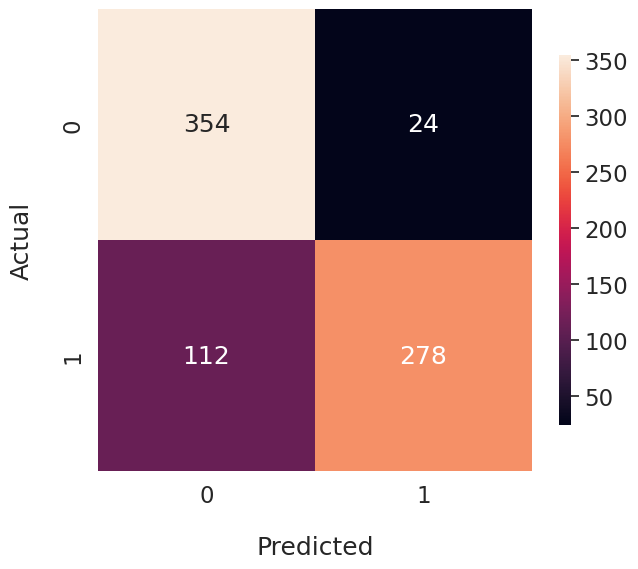

End evaluating!!!


In [61]:
classifier = EnsembleClassifier(
    "/kaggle/working/rnn_e7.pt",
    rnn_model,
    "/kaggle/working/lstm_e7.pt",
    lstm_model,
    "/kaggle/working/ann_e5.pt",
    ann_model,
    val_loader,
    device
)

classifier.acc_validate()